In [1]:
import numpy as np
from numpy import asarray
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage
from skimage.segmentation import clear_border
from skimage import data, exposure, img_as_float
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import label,regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go


c:\Users\rodhe\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(480, 640)


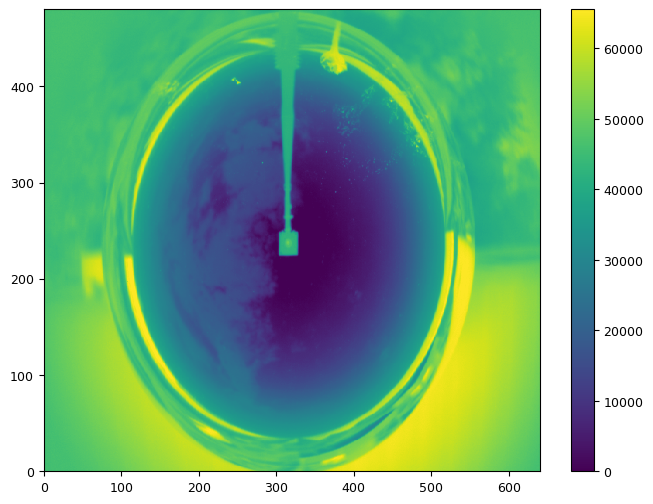

In [13]:
# filepath = '20230807_normal/20230807152030.png'
filepath = '20230807_normal/20230807163300.png'
img = Image.open(filepath)
img = asarray(img)
print(img.shape)
plt.figure(figsize=(8,6))
#÷plt.pcolormesh(img, cmap='Greys_r')
plt.pcolormesh(img)
plt.colorbar()

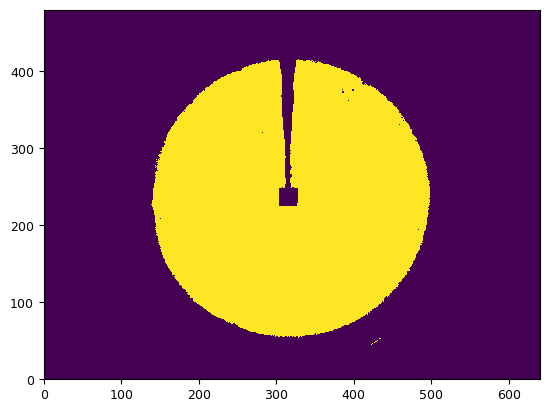

In [14]:
# mask =  (img < 30000) & (img > 10000)
mask =  (img < 30000)

plt.pcolormesh(mask)

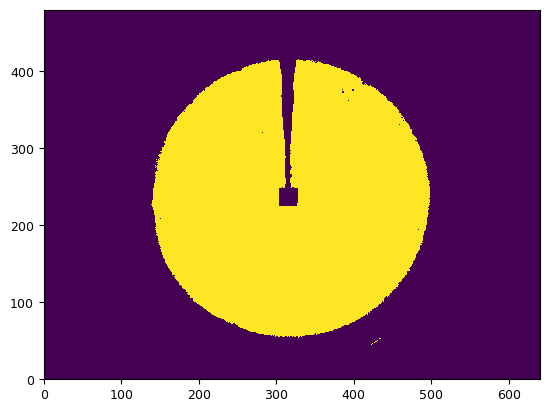

In [15]:
mask.shape
# mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)
mask = clear_border(mask)
plt.pcolormesh(mask)

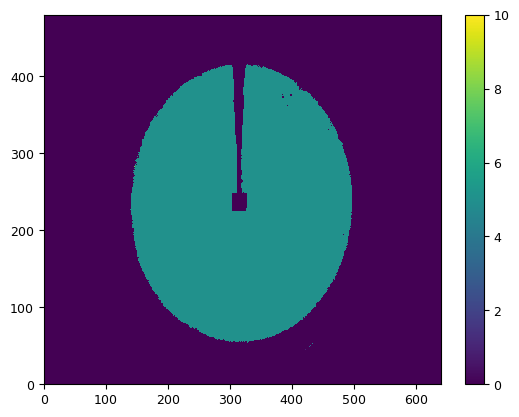

In [16]:
mask_labeled = label(mask)
plt.pcolormesh(mask_labeled)
plt.colorbar()


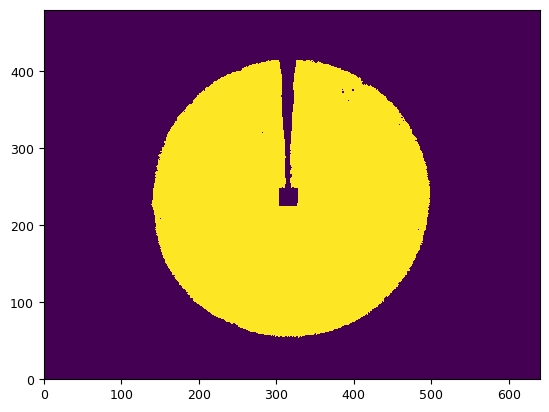

In [17]:
def remove_small(slc, c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

mask = remove_small(mask)
plt.pcolormesh(mask)


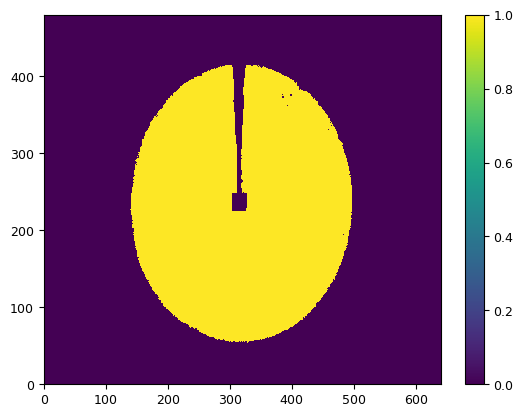

In [18]:
mask_labeled = label(mask)
plt.pcolormesh(mask_labeled)
plt.colorbar()

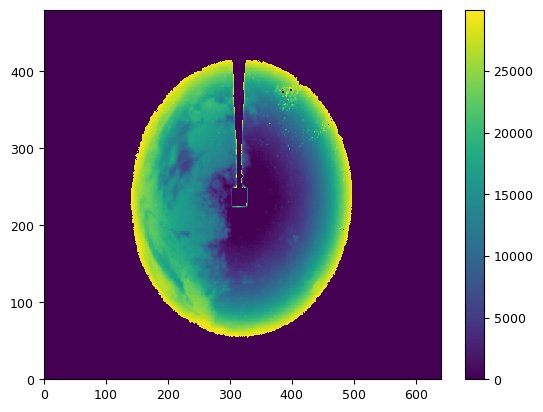

In [19]:
new_img = img * mask
plt.pcolormesh(new_img)
plt.colorbar()


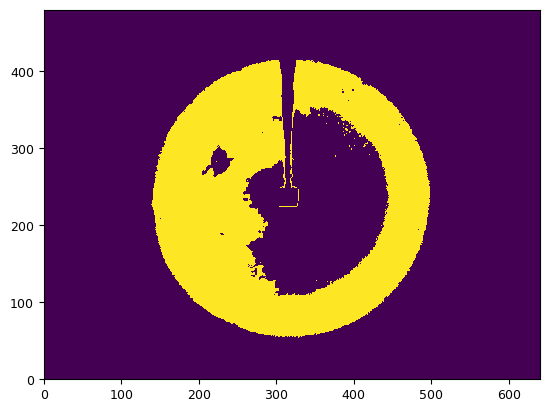

In [20]:
# mask =  (new_img < 30000) & (new_img > 500)
mask =  new_img > 10000
plt.pcolormesh(mask)



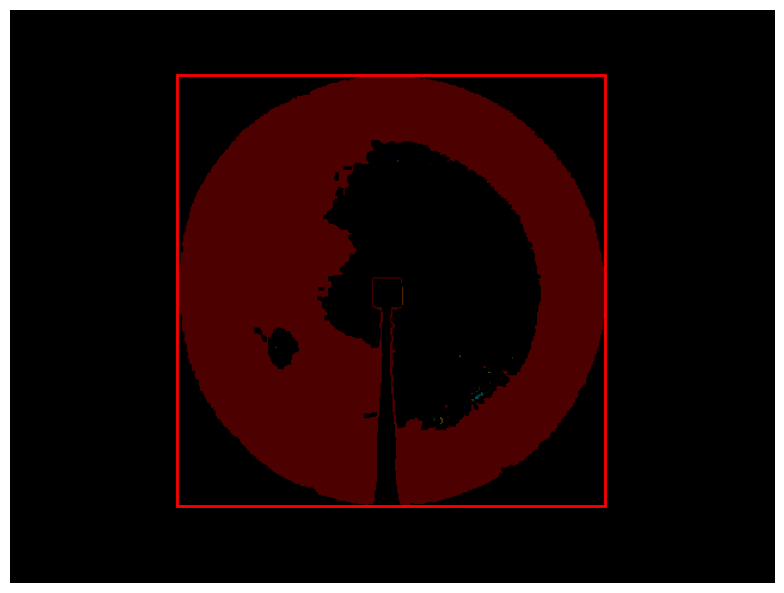

In [21]:
image = new_img
# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 50:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

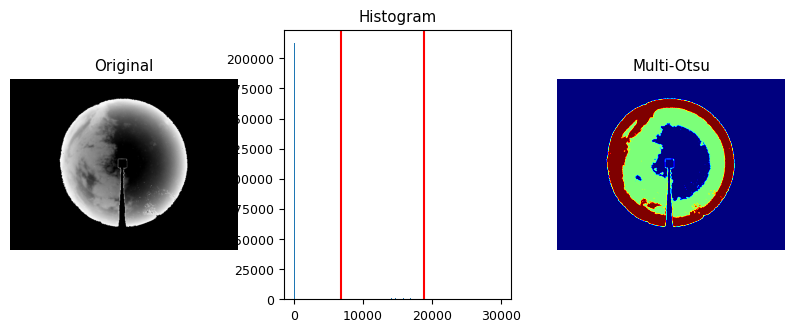

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = new_img

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

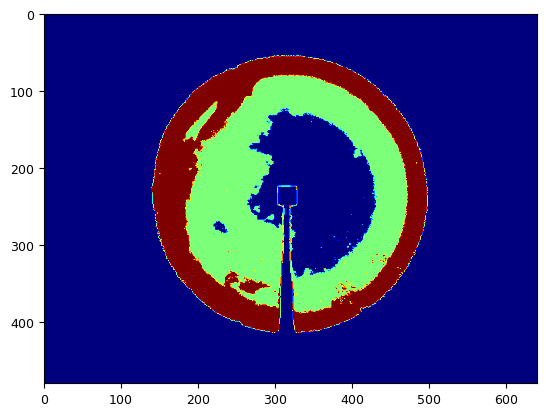

In [23]:
plt.imshow(regions, cmap='jet')

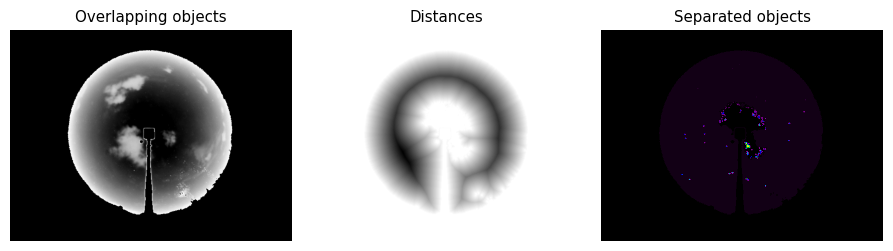

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# # Generate an initial image with two overlapping circles
# x, y = np.indices((80, 80))
# x1, y1, x2, y2 = 28, 28, 44, 52
# r1, r2 = 16, 20
# mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
# mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
# image = np.logical_or(mask_circle1, mask_circle2)

image = new_img

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

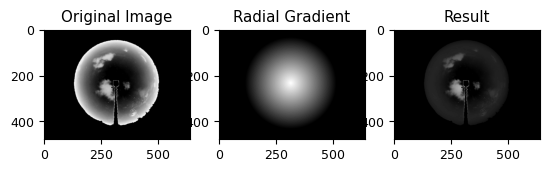

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def create_radial_gradient(size, center, radius):
    """
    Create a radial gradient from white to black.

    Parameters:
    - size: Tuple (height, width) specifying the size of the gradient.
    - center: Tuple (y, x) specifying the center of the gradient.
    - radius: Radius of the gradient.

    Returns:
    - gradient: NumPy array representing the radial gradient.
    """
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient):
    """
    Multiply a single-channel image with a gradient.

    Parameters:
    - image: NumPy array representing the single-channel image.
    - gradient: NumPy array representing the gradient.

    Returns:
    - result: NumPy array representing the multiplied image.
    """
    result = image * gradient
    return result

# Example usage:
# Create a single-channel sample image
image = new_img
image_size = img.shape


# Create a radial gradient from white to black
gradient_center = (235, 314)  # Center of the gradient
gradient_radius = 200  # Radius of the gradient
gradient = create_radial_gradient(image_size, gradient_center, gradient_radius)

# Multiply the image with the gradient
result = multiply_with_gradient(image, gradient)



# Display the original image, gradient, and the multiplied result
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gradient, cmap='gray')
plt.title('Radial Gradient')

plt.subplot(1, 3, 3)
plt.imshow(result, cmap='gray')
plt.title('Result')

plt.show()


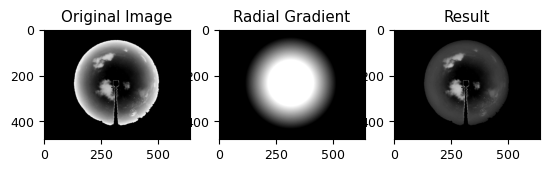

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def create_radial_gradient(size, center, radius1, target_value1, radius2, target_value2):
    """
    Create a radial gradient with two different radii and target values.

    Parameters:
    - size: Tuple (height, width) specifying the size of the gradient.
    - center: Tuple (y, x) specifying the center of the gradient.
    - radius1: Inner radius of the gradient.
    - target_value1: Target value at radius1.
    - radius2: Outer radius of the gradient.
    - target_value2: Target value at radius2.

    Returns:
    - gradient: NumPy array representing the radial gradient.
    """
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

    gradient = np.piecewise(distance,
                            [distance <= radius1, (radius1 < distance) & (distance <= radius2), distance > radius2],
                            [target_value1, lambda d: (target_value2 - target_value1) / (radius2 - radius1) * (d - radius1) + target_value1, target_value2])

    gradient = np.clip(gradient, 0, 255)
    gradient /= 255.0  # Normalize to the range [0, 1]

    return gradient

# Example usage:
# Create a single-channel sample image
image = new_img
image_size = img.shape

# Create a radial gradient with two different radii and target values
gradient_center = (235, 314)  # Center of the gradient
radius1, target_value1 = 100, 255
radius2, target_value2 = 200, 0
gradient = create_radial_gradient(image_size, gradient_center, radius1, target_value1, radius2, target_value2)

# Multiply the image with the gradient
result = multiply_with_gradient(image, gradient)

# Display the original image, gradient, and the multiplied result
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gradient, cmap='gray')
plt.title('Radial Gradient')

plt.subplot(1, 3, 3)
plt.imshow(result, cmap='gray')
plt.title('Result')

plt.show()


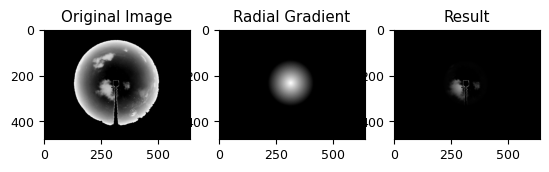

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def create_radial_gradient(size, center, radius1, initial_value, target_value1, radius2, target_value2, final_value):
    """
    Create a radial gradient with two different radii, initial and final values, and target values.

    Parameters:
    - size: Tuple (height, width) specifying the size of the gradient.
    - center: Tuple (y, x) specifying the center of the gradient.
    - radius1: Inner radius of the gradient.
    - initial_value: Initial value of the gradient.
    - target_value1: Target value at radius1.
    - radius2: Outer radius of the gradient.
    - target_value2: Target value at radius2.
    - final_value: Final value of the gradient.

    Returns:
    - gradient: NumPy array representing the radial gradient.
    """
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

    gradient = np.piecewise(distance,
                            [distance <= radius1,
                             (radius1 < distance) & (distance <= radius2),
                             distance > radius2],
                            [lambda d: (target_value1 - initial_value) / radius1 * d + initial_value,
                             lambda d: (target_value2 - target_value1) / (radius2 - radius1) * (d - radius1) + target_value1,
                             lambda d: (final_value - target_value2) / (distance.max() - radius2) * (d - radius2) + target_value2])

    gradient = np.clip(gradient, 0, 255)
    gradient /= 255.0  # Normalize to the range [0, 1]

    return gradient

# Example usage:
# Create a single-channel sample image
image = new_img
image_size = img.shape

# Set the final value of the inner radius as the starting value of the outer radius
gradient_center = (235, 314)  # Center of the gradient
radius1, initial_value, target_value1 = 100, 255, 1
radius2, target_value2, final_value = 200, target_value2, 0  # Use target_value2 as the starting value for outer radius
gradient = create_radial_gradient(image_size, gradient_center, radius1, initial_value, target_value1, radius2, target_value2, final_value)

# Multiply the image with the gradient
result = multiply_with_gradient(image, gradient)

# Display the original image, gradient, and the multiplied result
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gradient, cmap='gray')
plt.title('Radial Gradient')

plt.subplot(1, 3, 3)
plt.imshow(result, cmap='gray')
plt.title('Result')

plt.show()


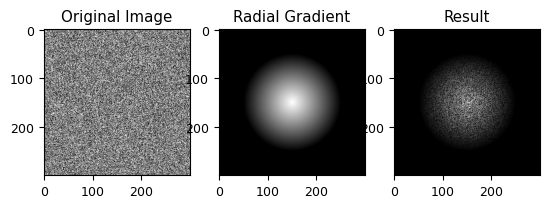

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def create_radial_gradient(size, center, radius):
    """
    Create a radial gradient from white to black.

    Parameters:
    - size: Tuple (height, width) specifying the size of the gradient.
    - center: Tuple (y, x) specifying the center of the gradient.
    - radius: Radius of the gradient.

    Returns:
    - gradient: NumPy array representing the radial gradient.
    """
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient, final_gray_value):
    """
    Multiply a single-channel image with a gradient and adjust final value to a specific gray level.

    Parameters:
    - image: NumPy array representing the single-channel image.
    - gradient: NumPy array representing the gradient.
    - final_gray_value: Value between 0 and 1 specifying the final gray level.

    Returns:
    - result: NumPy array representing the multiplied image with adjusted final gray level.
    """
    result = image * gradient
    result += (1 - gradient) * final_gray_value
    return result

# Example usage:
# Create a single-channel sample image
image_size = (300, 300)  # Height, Width
image = np.random.rand(*image_size)  # Random single-channel image for demonstration purposes

# Create a radial gradient from white to black
gradient_center = (150, 150)  # Center of the gradient
gradient_radius = 100  # Radius of the gradient
gradient = create_radial_gradient(image_size, gradient_center, gradient_radius)

# Adjust the final gray level
final_gray_level = 0  # Adjust as needed (between 0 and 1)

# Multiply the image with the gradient and adjust the final value to the specified gray level
result = multiply_with_gradient(image, gradient, final_gray_level)

# Display the original image, gradient, and the multiplied result
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gradient, cmap='gray')
plt.title('Radial Gradient')

plt.subplot(1, 3, 3)
plt.imshow(result, cmap='gray')
plt.title('Result')

plt.show()


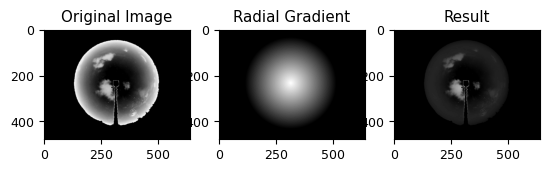

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def create_radial_gradient(size, center, radius):
    """
    Create a radial gradient from white to black.

    Parameters:
    - size: Tuple (height, width) specifying the size of the gradient.
    - center: Tuple (y, x) specifying the center of the gradient.
    - radius: Radius of the gradient.

    Returns:
    - gradient: NumPy array representing the radial gradient.
    """
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient):
    """
    Multiply a single-channel image with a gradient.

    Parameters:
    - image: NumPy array representing the single-channel image.
    - gradient: NumPy array representing the gradient.

    Returns:
    - result: NumPy array representing the multiplied image.
    """
    result = image * gradient
    return result

# Example usage:
# Create a single-channel sample image
image = new_img
image_size = img.shape


# Create a radial gradient from white to black
gradient_center = (235, 314)  # Center of the gradient
gradient_radius = 200  # Radius of the gradient
gradient = create_radial_gradient(image_size, gradient_center, gradient_radius)

# Multiply the image with the gradient
result = multiply_with_gradient(image, gradient)



# Display the original image, gradient, and the multiplied result
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gradient, cmap='gray')
plt.title('Radial Gradient')

plt.subplot(1, 3, 3)
plt.imshow(result, cmap='gray')
plt.title('Result')

plt.show()


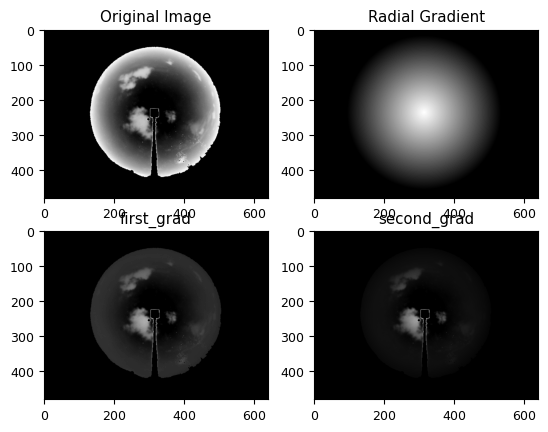

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def create_radial_gradient(size, center, radius):
    """
    Create a radial gradient from white to black.

    Parameters:
    - size: Tuple (height, width) specifying the size of the gradient.
    - center: Tuple (y, x) specifying the center of the gradient.
    - radius: Radius of the gradient.

    Returns:
    - gradient: NumPy array representing the radial gradient.
    """
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient):
    """
    Multiply a single-channel image with a gradient.

    Parameters:
    - image: NumPy array representing the single-channel image.
    - gradient: NumPy array representing the gradient.

    Returns:
    - result: NumPy array representing the multiplied image.
    """
    result = image * gradient
    return result

# Example usage:
# Create a single-channel sample image
image = new_img
image_size = img.shape


# Create a radial gradient from white to black
gradient_center = (235, 314)  # Center of the gradient
gradient_radius = 220  # Radius of the gradient
gradient = create_radial_gradient(image_size, gradient_center, gradient_radius)

# Multiply the image with the gradient
first_grad = multiply_with_gradient(image, gradient)


gradient_radius = 220  # Radius of the gradient
gradient = create_radial_gradient(image_size, gradient_center, gradient_radius)
second_grad = multiply_with_gradient(first_grad, gradient)



# Display the original image, gradient, and the multiplied result
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(gradient, cmap='gray')
plt.title('Radial Gradient')

plt.subplot(2, 2, 3)
plt.imshow(first_grad, cmap='gray')
plt.title('first_grad')

plt.subplot(2, 2, 4)
plt.imshow(second_grad, cmap='gray')
plt.title('second_grad')

plt.show()


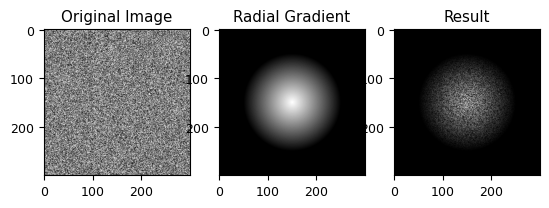

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def create_radial_gradient(size, center, radius, opacity):
    """
    Create a radial gradient from white to black with adjustable opacity.

    Parameters:
    - size: Tuple (height, width) specifying the size of the gradient.
    - center: Tuple (y, x) specifying the center of the gradient.
    - radius: Radius of the gradient.
    - opacity: Opacity of the gradient, a value between 0 and 1.

    Returns:
    - gradient: NumPy array representing the radial gradient.
    """
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = (1 - np.clip(distance / radius, 0, 1)) * opacity
    return gradient

def multiply_with_gradient(image, gradient):
    """
    Multiply a single-channel image with a gradient.

    Parameters:
    - image: NumPy array representing the single-channel image.
    - gradient: NumPy array representing the gradient.

    Returns:
    - result: NumPy array representing the multiplied image.
    """
    result = image * gradient
    return result

# Example usage:
# Create a single-channel sample image
image_size = (300, 300)  # Height, Width
image = np.random.rand(*image_size)  # Random single-channel image for demonstration purposes

# Create a radial gradient from white to black with opacity
gradient_center = (150, 150)  # Center of the gradient
gradient_radius = 100  # Radius of the gradient
gradient_opacity = 0.9  # Opacity of the gradient (adjust as needed)
gradient = create_radial_gradient(image_size, gradient_center, gradient_radius, gradient_opacity)

# Multiply the image with the gradient
result = multiply_with_gradient(image, gradient)

# Display the original image, gradient, and the multiplied result
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gradient, cmap='gray')
plt.title('Radial Gradient')

plt.subplot(1, 3, 3)
plt.imshow(result, cmap='gray')
plt.title('Result')

plt.show()


In [20]:
import cv2
import numpy as np



# Read the image
image = cv2.imread('20230807_normal/20230807163300.png')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Calculate the distance from the center of the image
rows, cols = gray.shape[:2]
y, x = np.ogrid[:rows, :cols]
center = (235, 314)
radius = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

# Apply vignette correction
strength = 1 # Adjust this value to control the strength of correction
vignette = 1.0 - (strength * radius / np.max(radius))
corrected_image = gray * vignette

# Convert the corrected image back to BGR
corrected_image = cv2.cvtColor(corrected_image.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Display the original and corrected images
cv2.imshow('Original Image', image)
cv2.imshow('Flattened Background', corrected_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
